In [142]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

dir = '../data/NF207/'
mat_file = dir + 'NF207_20190101_afa.mat'
mat_file = dir + 'NF207_20190101_comf_u.mat'
data = sio.loadmat(mat_file)
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Mic', 'fs', 'EGG', 'Flow', 'Pressure', 'ACC'])


In [143]:
import numpy as np
import scipy.io as sio

# EGG signal from NF207_20190101_afa.mat, has shape (1, N). We want (N, 1) to homogenize shapes.
def load_and_fix_structure(data, name):
    """
    Extracts the 'Data' field from the structure and ensures it has shape (N, 1).
    """
    struc = data.get(name)
    if struc is not None:
        if 'Data' in struc.dtype.names:
            data_field = struc['Data'][0, 0]
            if len(data_field.shape) == 1:  
                data_field = data_field.reshape(-1, 1)

            elif data_field.shape[0] == 1:
                data_field = data_field.T

            struc['Data'][0, 0] = data_field  
        return struc
    return None

# Load data
data = sio.loadmat(mat_file)

# Process structures with consistent 'Data' shapes
Mic_struc = load_and_fix_structure(data, 'Mic')
EGG_struc = load_and_fix_structure(data, 'EGG')
Flow_struc = load_and_fix_structure(data, 'Flow')
Pressure_struc = load_and_fix_structure(data, 'Pressure')
ACC_struc = load_and_fix_structure(data, 'ACC')
fs = data.get('fs')
# Verify fixed structures
for struc, name in [(Mic_struc, 'Mic'), (EGG_struc, 'EGG'), (Flow_struc, 'Flow'), (Pressure_struc, 'Pressure'), (ACC_struc, 'ACC')]:
    if struc is not None:
        print(f"Structure: {name}")
        print(f"Data Shape: {struc['Data'][0, 0].shape}")
    else:
        print(f"Structure {name} not found.")

Structure: Mic
Data Shape: (59120, 1)
Structure: EGG
Data Shape: (59120, 1)
Structure: Flow
Data Shape: (59120, 1)
Structure: Pressure
Data Shape: (59120, 1)
Structure: ACC
Data Shape: (59120, 1)


In [144]:
import pandas as pd

structures = [
    ('Mic', Mic_struc),
    ('EGG', EGG_struc),
    ('Flow', Flow_struc),
    ('Pressure', Pressure_struc),
    ('ACC', ACC_struc),
]


table_data = []
for name, struct in structures:
    struct_info = {}
    struct_info['Structure'] = name
    for field in struct.dtype.names:

        if field == 'Data':
            struct_info['Data'] = struct[field][0, 0]
            struct_info['Data Shape'] = struct[field][0, 0].shape

        elif field == 'MagSpectrum':
            struct_info['MagSpectrum'] = struct[field][0, 0]
            struct_info['MagSpectrum Shape'] = struct[field][0, 0].shape

        elif field == 'MagSpectrum_dB':
            struct_info['MagSpectrum_dB'] = struct[field][0, 0]
            struct_info['MagSpectrum_dB Shape'] = struct[field][0, 0].shape
        
        else:
            value = struct[field][0, 0]
            if isinstance(value, np.ndarray) and value.size == 1:
                struct_info[field] = value.item()  # Extract single value
            else:
                struct_info[field] = value  # Keep as-is if not a single value

    table_data.append(struct_info)

df = pd.DataFrame(table_data)


table = df.drop(columns=['Data', 'MagSpectrum', 'MagSpectrum_dB'])
table


,Structure,Data Shape,ChannelNumber,Units,Scale,Offset,Gain,LPF,HPF,ID,Scale_dB,MagSpectrum Shape,MagSpectrum_dB Shape
0,Mic,"(59120, 1)",1.0,Pa,14.337075,-0.004333,50.0,8000.0,0.0,NaN,NaN,NaN,NaN
1,EGG,"(59120, 1)",2.0,V,1.000000,0.000000,5.0,8000.0,0.0,NaN,NaN,NaN,NaN
2,Flow,"(59120, 1)",5.0,L/s,1.266837,-0.009704,5.0,8000.0,0.0,NaN,NaN,NaN,NaN
3,Pressure,"(59120, 1)",6.0,cm H2O,100.552207,-0.053994,20.0,8000.0,0.0,NaN,NaN,NaN,NaN
4,ACC,"(59120, 1)",NaN,cm/(s^2),22982.335953,0.000000,4.5,NaN,NaN,151,87.227883,"(265, 1)","(265, 1)"


In [145]:

# Filter rows for Mic and ACC signals
mic_data = df.loc[df['Structure'] == 'Mic', 'Data'].iloc[0]  # Extract Mic Data
acc_data = df.loc[df['Structure'] == 'ACC', 'Data'].iloc[0]  # Extract ACC Data

# Ensure the data is a NumPy array and flatten it
mic_data = np.array(mic_data).flatten()
acc_data = np.array(acc_data).flatten()

# Time vector based on data length and sampling frequency
mic_time = np.arange(0, len(mic_data)) / fs
acc_time = np.arange(0, len(acc_data)) / fs

mic_time = mic_time.flatten()
acc_time = acc_time.flatten()


In [146]:
from IPython.display import Audio

Audio(data=mic_data, rate=int(fs))


/tmp/ipykernel_119067/2030793941.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Audio(data=mic_data, rate=int(fs))


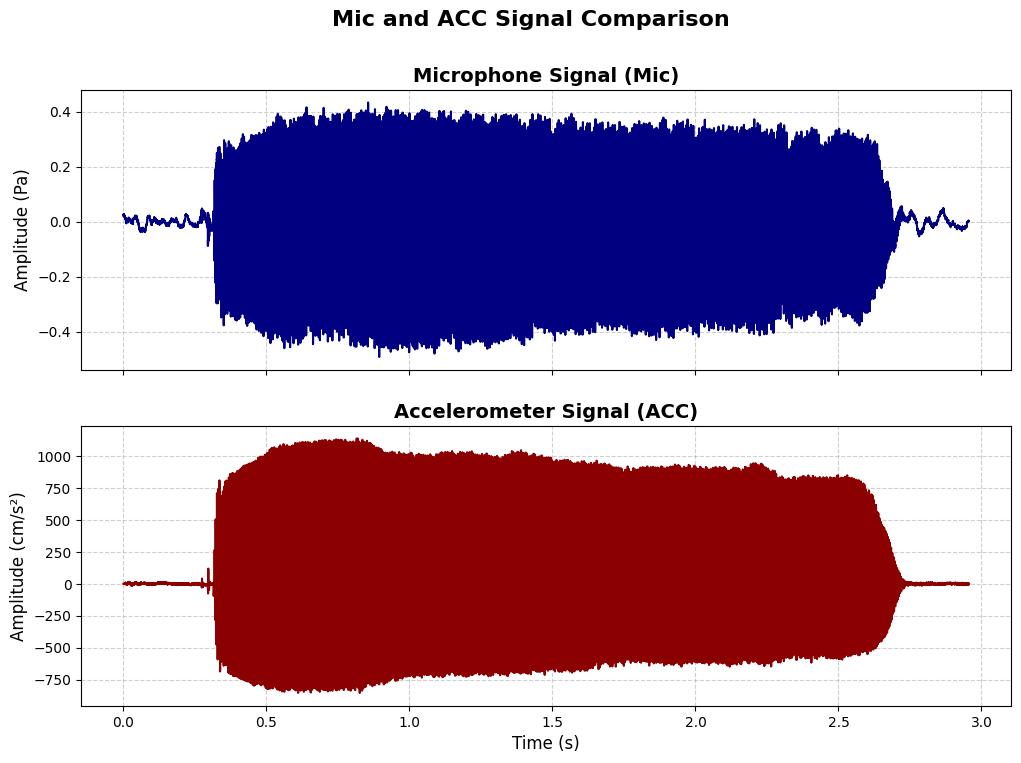

In [147]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Mic Signal Plot
ax[0].plot(mic_time, mic_data, color='navy', linewidth=1.5)
ax[0].set_title('Microphone Signal (Mic)', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Amplitude (Pa)', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.6)

# ACC Signal Plot
ax[1].plot(acc_time, acc_data, color='darkred', linewidth=1.5)
ax[1].set_title('Accelerometer Signal (ACC)', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Amplitude (cm/s²)', fontsize=12)
ax[1].set_xlabel('Time (s)', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Mic and ACC Signal Comparison', fontsize=16, fontweight='bold')

# Show the plot
plt.show()


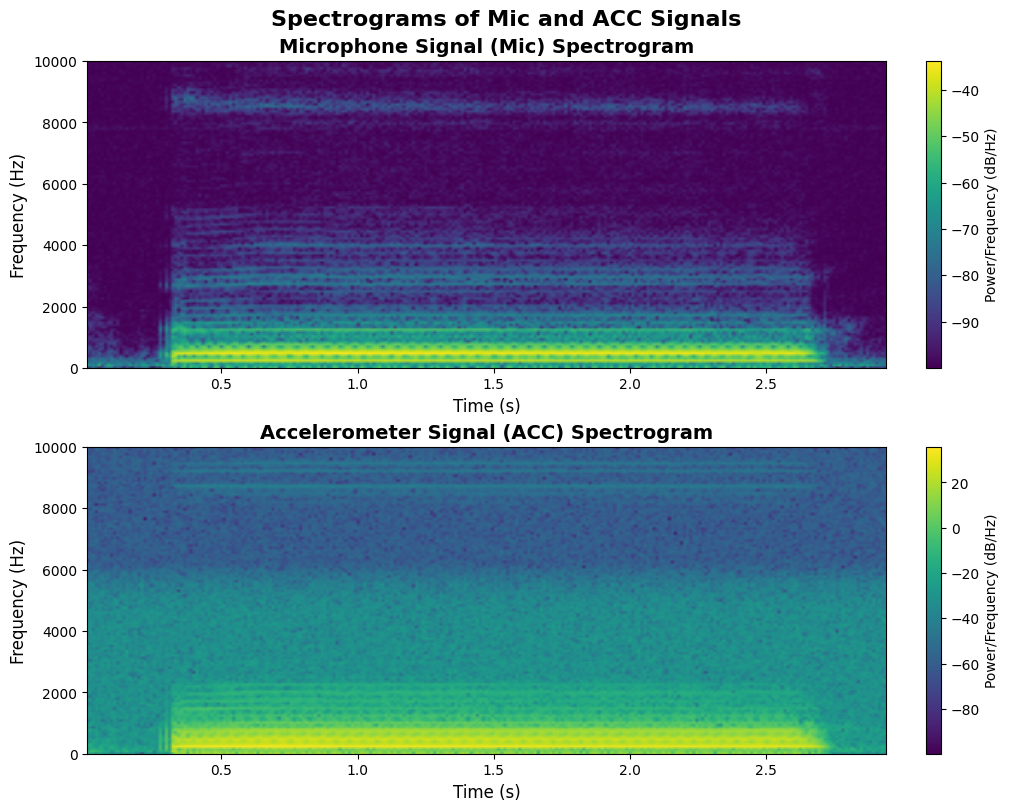

In [148]:
from scipy.signal import spectrogram

# Ensure signals are 1D
mic_data = np.array(mic_data).flatten()
acc_data = np.array(acc_data).flatten()

def plot_spectrogram(signal, fs, title, ax, cmap='viridis'):
    f, t, Sxx = spectrogram(signal, fs)  # Compute the spectrogram

    im = ax.pcolormesh(t, f.flatten(), 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap=cmap)  # Use correct shading
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('Frequency (Hz)', fontsize=12)
    ax.set_xlabel('Time (s)', fontsize=12)
    return im

# Create the figure and axes
fig, ax = plt.subplots(2, 1, figsize=(10, 8), constrained_layout=True)

# Mic Spectrogram
im1 = plot_spectrogram(mic_data, fs, 'Microphone Signal (Mic) Spectrogram', ax[0])

# ACC Spectrogram
im2 = plot_spectrogram(acc_data, fs, 'Accelerometer Signal (ACC) Spectrogram', ax[1])

# Add colorbars
fig.colorbar(im1, ax=ax[0], orientation='vertical', label='Power/Frequency (dB/Hz)')
fig.colorbar(im2, ax=ax[1], orientation='vertical', label='Power/Frequency (dB/Hz)')

# Overall title
plt.suptitle('Spectrograms of Mic and ACC Signals', fontsize=16, fontweight='bold')
plt.show()